  school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  ...  \
0     GP   F   18       U     GT3       A     4     4  at_home   teacher  ...   
1     GP   F   17       U     GT3       T     1     1  at_home     other  ...   
2     GP   F   15       U     LE3       T     1     1  at_home     other  ...   
3     GP   F   15       U     GT3       T     4     2   health  services  ...   
4     GP   F   16       U     GT3       T     3     3    other     other  ...   

  famrel freetime  goout  Dalc  Walc health absences  G1  G2  G3  
0      4        3      4     1     1      3        6   5   6   6  
1      5        3      3     1     1      3        4   5   5   6  
2      4        3      2     2     3      3       10   7   8  10  
3      3        2      2     1     1      5        2  15  14  15  
4      4        3      2     1     2      5        4   6  10  10  

[5 rows x 33 columns]
Validación Cruzada (Entrenamiento Sin Balancear): Accuracy: 0.74 ± 0.01
Validación Cruza

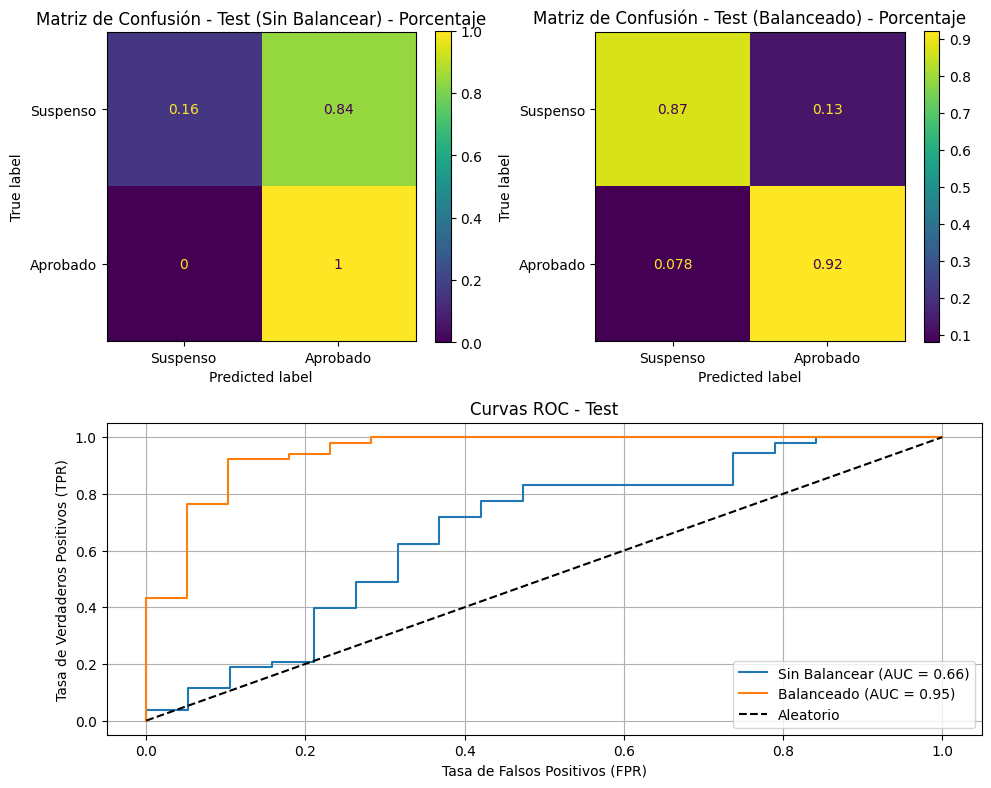

/var/folders/fm/9pzntrns5_s8x46kp5sm9x240000gn/T/ipykernel_17519/1691812686.py:120: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y, palette='viridis')
/var/folders/fm/9pzntrns5_s8x46kp5sm9x240000gn/T/ipykernel_17519/1691812686.py:128: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_balanced, palette='viridis')


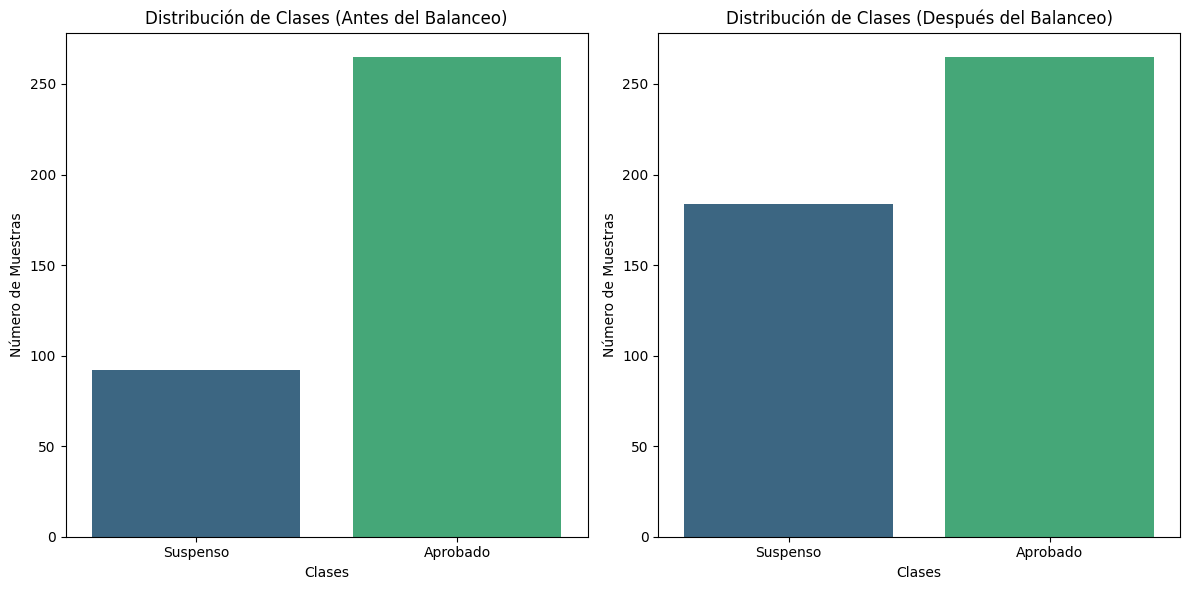

In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Importar datos
df = pd.read_csv('student-mat.csv')

df = df[df['G3'] != 0]

print(df.head())

# 2. Preprocesamiento de datos
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

X = df.drop(['G3', 'G2', 'G1'], axis=1)
y = (df['G3'] >= 10).astype(int)

# Balancear manualmente las clases
y_counts = y.value_counts()
minority_class = y_counts.idxmin()
minority_indices = y[y == minority_class].index
additional_minority_samples = X.loc[minority_indices]
X_balanced = pd.concat([X, additional_minority_samples], axis=0)
y_balanced = pd.concat([y, pd.Series([minority_class] * len(minority_indices), index=additional_minority_samples.index)])

# Escalar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_balanced_scaled = scaler.fit_transform(X_balanced)

# Paso 1: División inicial en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced = train_test_split(X_balanced_scaled, y_balanced, test_size=0.2, random_state=42)

# Paso 2: Validación cruzada en el conjunto de entrenamiento
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)

# Métricas de validación cruzada (sin balancear)
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=cv, scoring='accuracy')
print(f"Validación Cruzada (Entrenamiento Sin Balancear): Accuracy: {np.mean(cv_scores):.2f} ± {np.std(cv_scores):.2f}")

# Métricas de validación cruzada (balanceado)
cv_scores_balanced = cross_val_score(rf_model, X_train_balanced, y_train_balanced, cv=cv, scoring='accuracy')
print(f"Validación Cruzada (Entrenamiento Balanceado): Accuracy: {np.mean(cv_scores_balanced):.2f} ± {np.std(cv_scores_balanced):.2f}")

# Entrenar el modelo final con los datos de entrenamiento completos
rf_model.fit(X_train, y_train)

# Paso 3: Evaluar en el conjunto de prueba (sin balancear)
y_pred_test = rf_model.predict(X_test)
y_proba_test = rf_model.predict_proba(X_test)[:, 1]

# Evaluar en el conjunto de prueba (balanceado)
rf_model.fit(X_train_balanced, y_train_balanced)
y_pred_test_balanced = rf_model.predict(X_test_balanced)
y_proba_test_balanced = rf_model.predict_proba(X_test_balanced)[:, 1]

# Métricas en el conjunto de prueba (sin balancear)
print("\nResultados en el Conjunto de Prueba (Sin Balancear):")
print(f"Accuracy: {accuracy_score(y_test, y_pred_test):.2f}")
print(f"Precision: {precision_score(y_test, y_pred_test):.2f}")
print(f"Recall: {recall_score(y_test, y_pred_test):.2f}")
print(f"F1 Score: {f1_score(y_test, y_pred_test):.2f}")
print(f"AUC: {roc_auc_score(y_test, y_proba_test):.2f}")

# Métricas en el conjunto de prueba (balanceado)
print("\nResultados en el Conjunto de Prueba (Balanceado):")
print(f"Accuracy: {accuracy_score(y_test_balanced, y_pred_test_balanced):.2f}")
print(f"Precision: {precision_score(y_test_balanced, y_pred_test_balanced):.2f}")
print(f"Recall: {recall_score(y_test_balanced, y_pred_test_balanced):.2f}")
print(f"F1 Score: {f1_score(y_test_balanced, y_pred_test_balanced):.2f}")
print(f"AUC: {roc_auc_score(y_test_balanced, y_proba_test_balanced):.2f}")

# Matrices de confusión con porcentajes
cm_unbalanced_test = confusion_matrix(y_test, y_pred_test, normalize='true')
cm_balanced_test = confusion_matrix(y_test_balanced, y_pred_test_balanced, normalize='true')

# ROC Curves
fpr_unbalanced, tpr_unbalanced, _ = roc_curve(y_test, y_proba_test)
auc_unbalanced = roc_auc_score(y_test, y_proba_test)

fpr_balanced, tpr_balanced, _ = roc_curve(y_test_balanced, y_proba_test_balanced)
auc_balanced = roc_auc_score(y_test_balanced, y_proba_test_balanced)

# Gráficos
plt.figure(figsize=(10, 8))
ConfusionMatrixDisplay(cm_unbalanced_test, display_labels=["Suspenso", "Aprobado"]).plot(cmap="viridis", ax=plt.subplot(2, 2, 1))
plt.title("Matriz de Confusión - Test (Sin Balancear) - Porcentaje")

ConfusionMatrixDisplay(cm_balanced_test, display_labels=["Suspenso", "Aprobado"]).plot(cmap="viridis", ax=plt.subplot(2, 2, 2))
plt.title("Matriz de Confusión - Test (Balanceado) - Porcentaje")

plt.subplot(2, 1, 2)
plt.plot(fpr_unbalanced, tpr_unbalanced, label=f"Sin Balancear (AUC = {auc_unbalanced:.2f})")
plt.plot(fpr_balanced, tpr_balanced, label=f"Balanceado (AUC = {auc_balanced:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Aleatorio")
plt.title("Curvas ROC - Test")
plt.xlabel("Tasa de Falsos Positivos (FPR)")
plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
plt.legend(loc="lower right")
plt.grid()

plt.tight_layout()
plt.show()

# Gráficos de distribución de clases antes y después del balanceo
plt.figure(figsize=(12, 6))

# Antes del balanceo
plt.subplot(1, 2, 1)
sns.countplot(x=y, palette='viridis')
plt.title("Distribución de Clases (Antes del Balanceo)")
plt.xlabel("Clases")
plt.ylabel("Número de Muestras")
plt.xticks(ticks=[0, 1], labels=["Suspenso", "Aprobado"])

# Después del balanceo
plt.subplot(1, 2, 2)
sns.countplot(x=y_balanced, palette='viridis')
plt.title("Distribución de Clases (Después del Balanceo)")
plt.xlabel("Clases")
plt.ylabel("Número de Muestras")
plt.xticks(ticks=[0, 1], labels=["Suspenso", "Aprobado"])

plt.tight_layout()
plt.show()
